# **Installation**

In [1]:
!pip install kaggle
!pip install fitter
!pip install pyodbc
!pip install python-dotenv
!pip install prophet
!pip install catboost
!pip install python-dotenv
!pip install category_encoders
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 47.4 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.7/334.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.6 MB/s eta 0:00:00


from google.colab import files
files.upload()

# **Upload Files**

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c store-sales-time-series-forecasting
!unzip store-sales-time-series-forecasting.zip -d /content/store-sales-data

 94% 20.0M/21.4M [00:00<00:00, 204MB/s]
100% 21.4M/21.4M [00:00<00:00, 208MB/s]
Archive:  store-sales-time-series-forecasting.zip
  inflating: /content/store-sales-data/holidays_events.csv  
  inflating: /content/store-sales-data/oil.csv  
  inflating: /content/store-sales-data/sample_submission.csv  
  inflating: /content/store-sales-data/stores.csv  
  inflating: /content/store-sales-data/test.csv  
  inflating: /content/store-sales-data/train.csv  
  inflating: /content/store-sales-data/transactions.csv  


# **Imports**

In [ ]:
# Data Handling
import pyodbc
from dotenv import dotenv_values
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
import matplotlib.dates as mdates

# Statistical Analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from scipy.stats import f_oneway, pearsonr

# Feature Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import category_encoders as ce
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle
from lightgbm import LGBMRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Other Packages
import warnings
warnings.filterwarnings("ignore")

# **Load the data**

In [59]:
holidays_events = pd.read_csv('/content/store-sales-data/holidays_events.csv')
oil = pd.read_csv('/content/store-sales-data/oil.csv')
sample_submission = pd.read_csv('/content/store-sales-data/sample_submission.csv')
stores = pd.read_csv('/content/store-sales-data/stores.csv')
test = pd.read_csv('/content/store-sales-data/test.csv')
train = pd.read_csv('/content/store-sales-data/train.csv')
transactions = pd.read_csv('/content/store-sales-data/transactions.csv')

In [48]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


# **Preprocessing**

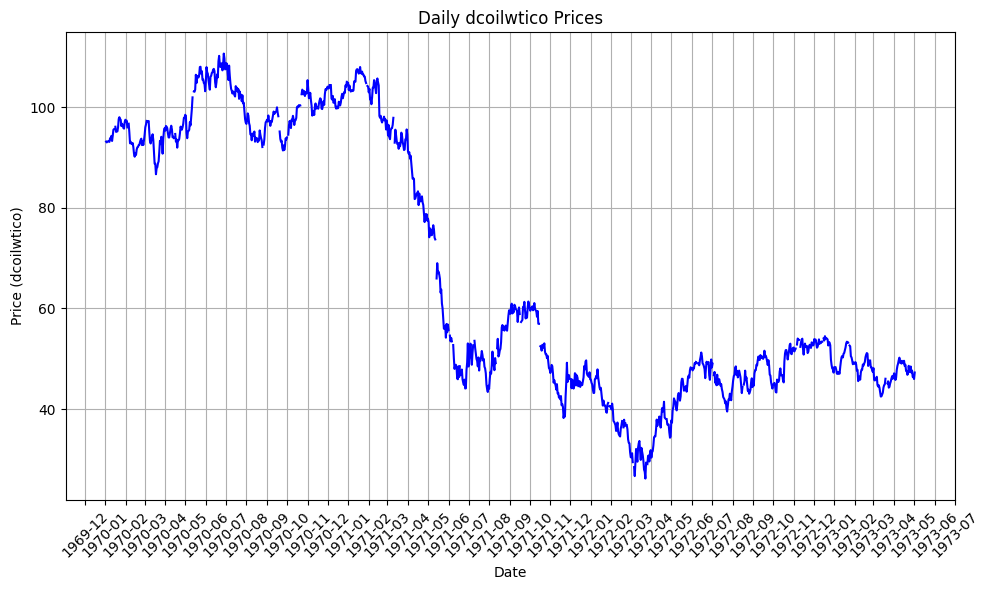

In [60]:
# Visualize the oil prices
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.plot(oil['date'], oil['dcoilwtico'], color='blue')  # Create a line graph
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Price (dcoilwtico)')  # Label for the y-axis
plt.title('Daily dcoilwtico Prices')  # Title of the graph

# Set x-axis major locator to months and formatter to show years and months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))  # Major ticks every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format labels to show year and month

# Optionally, add a secondary locator to highlight quarters
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=1))  # Minor ticks every month
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%b'))  # Format labels to show month names

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust the layout
plt.grid(True)  # Optional: add gridlines for better readability
plt.show()  # Display the graph

In [61]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='backfill')


In [62]:

# Create a full date range from the minimum to maximum date in the oil table
full_date_range = pd.date_range(start=oil['date'].min(), end=oil['date'].max())
# Reindex the oil DataFrame to include all dates
oil_df_full = oil.set_index('date').reindex(full_date_range).reset_index()

# Rename the index column back to 'date'
oil_df_full = oil_df_full.rename(columns={'index': 'date'})
# Now identify the missing dates
missing_dates = oil_df_full[oil_df_full['dcoilwtico'].isna()]['date']
print(f"Missing Dates in Oil Table: {missing_dates}")

# Prepare the data for Prophet
oil_df_prophet = oil_df_full[['date', 'dcoilwtico']].rename(columns={'date': 'ds', 'dcoilwtico': 'y'})

# Train the Prophet model
model = Prophet()
model.fit(oil_df_prophet.dropna())

# Make future dataframe including missing dates
future = model.make_future_dataframe(periods=0, freq='D')
forecast = model.predict(future)

# Fill the missing values with the predicted values
oil_df_full['dcoilwtico'] = oil_df_full['dcoilwtico'].fillna(forecast.set_index('ds')['yhat'])
# Display the updated DataFrame
# Check for remaining missing values
# Fill with a rolling mean
oil_df_full['dcoilwtico'] = oil_df_full['dcoilwtico'].fillna(oil_df_full['dcoilwtico'].rolling(window=7, min_periods=1).mean())


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv6ag6yff/ov8bbpgb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv6ag6yff/1e18y7sf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70663', 'data', 'file=/tmp/tmpv6ag6yff/ov8bbpgb.json', 'init=/tmp/tmpv6ag6yff/1e18y7sf.json', 'output', 'file=/tmp/tmpv6ag6yff/prophet_modelf02zvthm/prophet_model-20241010083915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Missing Dates in Oil Table: 4      2013-01-05
5      2013-01-06
11     2013-01-12
12     2013-01-13
18     2013-01-19
          ...    
1685   2017-08-13
1691   2017-08-19
1692   2017-08-20
1698   2017-08-26
1699   2017-08-27
Name: date, Length: 486, dtype: datetime64[ns]


08:39:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


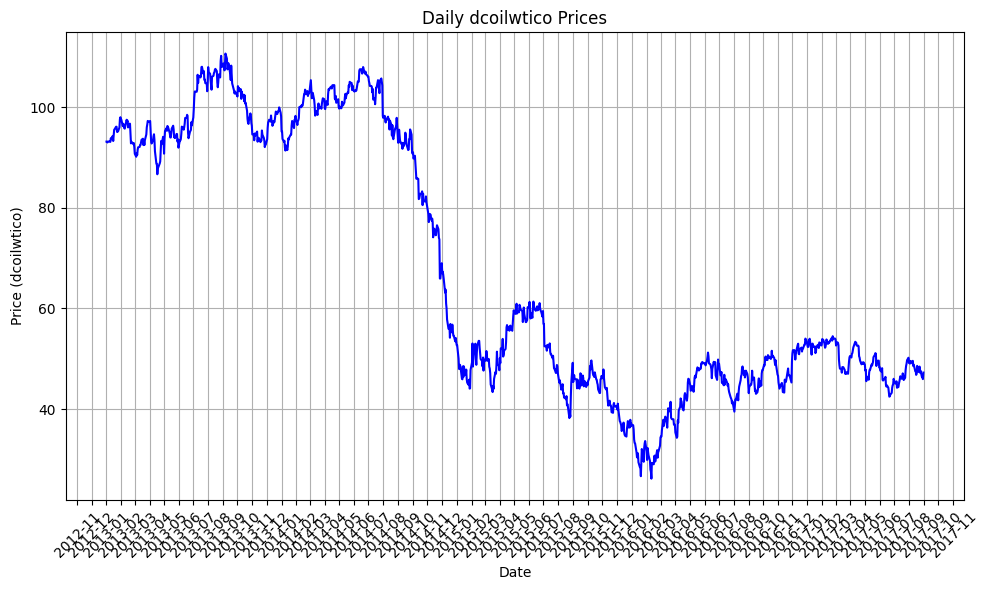

In [63]:
# Visualize the oil prices after filling missing values

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.plot(oil['date'], oil['dcoilwtico'], color='blue')  # Create a line graph
plt.xlabel('Date')  # Label for the x-axis
plt.ylabel('Price (dcoilwtico)')  # Label for the y-axis
plt.title('Daily dcoilwtico Prices')  # Title of the graph

# Set x-axis major locator to months and formatter to show years and months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))  # Major ticks every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format labels to show year and month

# Optionally, add a secondary locator to highlight quarters
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=1))  # Minor ticks every month
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%b'))  # Format labels to show month names

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust the layout
plt.grid(True)  # Optional: add gridlines for better readability
plt.show()  # Display the graph

In [64]:
# Group by the date and sum the sales
sales_sum_by_date = train.groupby(['date','store_nbr'])['sales'].sum()
# Add the total sales by date as a new column in the filtered DataFrame
transactions = transactions.merge(sales_sum_by_date, on = ['date','store_nbr'], how = 'left')
transactions.rename(columns={'sales': 'sum_sales'}, inplace=True)

In [65]:
holidays_events = holidays_events[holidays_events['transferred'] != True]

holidays_events.drop('transferred', axis=1, inplace=True)
# Define a custom aggregation function
def merge_values(series):
    # Combine all unique values into a single list
    return ', '.join(series.unique())

# Group by the 'date' column and aggregate
merged_holidays = holidays_events.groupby('date').agg({
    'type': merge_values,
    'locale': merge_values,
    'locale_name': merge_values,
    'description': merge_values
}).reset_index()

# Merging tables

In [66]:
train = train.merge(oil_df_full, on ='date' , how = 'inner')
train = train.merge(stores, on ='store_nbr' , how = 'left')
train = train.merge(transactions, on =['date','store_nbr'] , how = 'left')
train = train.merge(merged_holidays, on =['date'] , how = 'left')


test = test.merge(oil_df_full, on ='date' , how = 'left')
test = test.merge(transactions, on =['date','store_nbr'] , how = 'left')
test = test.merge(merged_holidays, on =['date'] , how = 'left')
test = test.merge(stores, on='store_nbr', how='left')

# Null Handeling

In [67]:
train['locale'].fillna('Unknown', inplace=True)
train['locale_name'].fillna('Unknown', inplace=True)
train['description'].fillna('Unknown', inplace=True)

train['transactions'].fillna(0, inplace=True)
train['sum_sales'].fillna(0, inplace=True)
train.drop(['type_y'], axis=1, inplace=True)

test['locale'].fillna('Unknown', inplace=True)
test['locale_name'].fillna('Unknown', inplace=True)
test['description'].fillna('Unknown', inplace=True)
test['type_x'].fillna('Unknown', inplace=True)

test['transactions'].fillna(0, inplace=True)
test['sum_sales'].fillna(0, inplace=True)
test.drop(['type_y'], axis=1, inplace=True)

In [68]:
train['date'] = pd.to_datetime(train['date'])
train_monthly = train.groupby([train['date'].dt.to_period('M'), 'store_nbr', 'family']).agg({
    'sales': 'sum',
    'transactions': 'sum',
    'sum_sales': 'mean',
}).reset_index()

test['date'] = pd.to_datetime(test['date'])
test_monthly = test.groupby([test['date'].dt.to_period('M'), 'store_nbr', 'family']).agg({
    'transactions': 'sum',
    'sum_sales': 'mean',
}).reset_index()

In [69]:
train.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
dcoilwtico,0
city,0
state,0
type_x,0


In [70]:
print(f"Train columns: {train.columns}")
print(f"Test columns: {test.columns}")

missing_cols = set(train.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0

print(f"Train columns after modification: {train.columns}")
print(f"Test columns after modification: {test.columns}")

Train columns: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'dcoilwtico', 'city', 'state', 'type_x', 'cluster', 'transactions',
       'sum_sales', 'locale', 'locale_name', 'description'],
      dtype='object')
Test columns: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'dcoilwtico',
       'transactions', 'sum_sales', 'type_x', 'locale', 'locale_name',
       'description', 'city', 'state', 'cluster'],
      dtype='object')
Train columns after modification: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'dcoilwtico', 'city', 'state', 'type_x', 'cluster', 'transactions',
       'sum_sales', 'locale', 'locale_name', 'description'],
      dtype='object')
Test columns after modification: Index(['id', 'date', 'store_nbr', 'family', 'onpromotion', 'dcoilwtico',
       'transactions', 'sum_sales', 'type_x', 'locale', 'locale_name',
       'description', 'city', 'state', 'cluster', 'sales'],
      dtype='object')


In [71]:

# Date breakdown
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day_of_week'] = train['date'].dt.dayofweek
train['day_of_year'] = train['date'].dt.dayofyear
train['week_of_year'] = train['date'].dt.isocalendar().week

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day_of_week'] = test['date'].dt.dayofweek
test['day_of_year'] = test['date'].dt.dayofyear
test['week_of_year'] = test['date'].dt.isocalendar().week

train = train.drop(columns=['date'])
test = test.drop(columns=['date'])

# Encoding
we choose Target Encoding

In [72]:
encoder = ce.TargetEncoder(cols=['store_nbr', 'family', 'city', 'state', 'type_x', 'locale','locale_name','description'])
train_encoded = encoder.fit_transform(train, train['sales'])
test_encoded = encoder.transform(test)

# **Feature Selection**

# Significance Test
The check_significance_and_plot function loops through all the columns in the DataFrame, identifying whether the column is numeric or categorical. For numeric columns, it performs the Pearson test. For categorical columns, it performs the ANOVA test. The results are recorded in a new DataFrame and then represented in a bar graph where the x-axis represents the P-value, that is, how significant the column is in relation to sales. Once you run the function, you can easily identify which variables are statistically significant against sales.

In [73]:
def check_significance_and_create_table(df, target_column):
    significance_results = []

    for column in df.columns:
        if column == target_column:
            continue

        # Check for missing values
        if df[column].isnull().sum() > 0:
            print(f"Skipping column {column} due to missing values.")
            continue

        if pd.api.types.is_numeric_dtype(df[column]):
            # Numerical column - use Pearson correlation
            try:
                corr, p_value = pearsonr(df[column], df[target_column])
                significance_results.append([column, p_value, 'Pearson', 'Yes' if p_value < 0.01 else 'No'])
            except Exception as e:
                print(f"Error processing {column}: {e}")

        else:
            # Categorical column - use ANOVA
            try:
                categories = df[column].unique()
                sales_by_category = [df[df[column] == cat][target_column] for cat in categories]
                _, p_value = f_oneway(*sales_by_category)
                significance_results.append([column, p_value, 'ANOVA', 'Yes' if p_value < 0.05 else 'No'])
            except Exception as e:
                print(f"Error processing {column}: {e}")

    # Create DataFrame for significance results
    significance_df = pd.DataFrame(significance_results, columns=['Feature', 'P-value', 'Test Type', 'Significant'])

    # Display the table
    return significance_df

# Call the function on the train dataset
significance_table = check_significance_and_create_table(train_encoded, 'sales')
significance_table

,Feature,P-value,Test Type,Significant
0,id,0.000000e+00,Pearson,Yes
1,store_nbr,0.000000e+00,Pearson,Yes
2,family,0.000000e+00,Pearson,Yes
3,onpromotion,0.000000e+00,Pearson,Yes
4,dcoilwtico,0.000000e+00,Pearson,Yes
5,city,0.000000e+00,Pearson,Yes
6,state,0.000000e+00,Pearson,Yes
7,type_x,0.000000e+00,Pearson,Yes
8,cluster,0.000000e+00,Pearson,Yes
9,transactions,0.000000e+00,Pearson,Yes


# RFE
Choose the best features

In [79]:
model = LinearRegression()

rfe = RFE(estimator=model, n_features_to_select=18)

X = train_encoded.drop(columns=['sales'])
y = train_encoded['sales']

rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

X_selected = X[selected_features]


Selected Features: Index(['id', 'store_nbr', 'family', 'onpromotion', 'dcoilwtico', 'city',
       'state', 'type_x', 'cluster', 'transactions', 'sum_sales', 'locale',
       'description', 'year', 'month', 'day_of_week', 'day_of_year',
       'week_of_year'],
      dtype='object')


In [75]:
X_selected

,family,onpromotion,dcoilwtico,cluster,locale,year,month,day_of_week,day_of_year,week_of_year
0,6.101236,0,93.14,13,416.988209,2013,1,1,1,1
1,0.110528,0,93.14,13,416.988209,2013,1,1,1,1
2,3.715723,0,93.14,13,416.988209,2013,1,1,1,1
3,2385.793151,0,93.14,13,416.988209,2013,1,1,1,1
4,0.070797,0,93.14,13,416.988209,2013,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
3000883,350.532292,0,47.57,6,351.128132,2017,8,1,227,33
3000884,96.770202,1,47.57,6,351.128132,2017,8,1,227,33
3000885,1349.352123,148,47.57,6,351.128132,2017,8,1,227,33
3000886,2.961599,8,47.57,6,351.128132,2017,8,1,227,33


In [77]:

model = LinearRegression()

results = []

for n_features in range(5, 21):
    rfe = RFE(estimator=model, n_features_to_select=n_features)

    rfe.fit(X, y)

    selected_features = X.columns[rfe.support_]

    X_selected = X[selected_features]

    X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    rmse = mean_squared_error(y_val, y_pred, squared=False)

    results.append((n_features, rmse))

for n, score in results:
    print(f"Number of features: {n}, RMSE: {score}")


from sklearn.model_selection import cross_val_score

for n_features in range(5, 21):
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe.fit(X, y)
    selected_features = X.columns[rfe.support_]
    X_selected = X[selected_features]

    scores = cross_val_score(model, X_selected, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = (-scores)**0.5

    print(f"Number of features: {n_features}, Mean RMSE: {rmse_scores.mean()}")


Number of features: 5, RMSE: 1006.1570985863732
Number of features: 6, RMSE: 1006.038520822742
Number of features: 7, RMSE: 1005.709978945536
Number of features: 8, RMSE: 1005.7003226042406
Number of features: 9, RMSE: 759.1298310911885
Number of features: 10, RMSE: 759.0394678600832
Number of features: 11, RMSE: 708.1893204814064
Number of features: 12, RMSE: 708.1912924790201
Number of features: 13, RMSE: 708.1909506827908
Number of features: 14, RMSE: 708.1998576991055
Number of features: 15, RMSE: 708.199187963502
Number of features: 16, RMSE: 708.1982122708667
Number of features: 17, RMSE: 708.1904142171196
Number of features: 18, RMSE: 708.1800418004576
Number of features: 19, RMSE: 708.1811427605915
Number of features: 20, RMSE: 708.1811427605915
Number of features: 5, Mean RMSE: 989.3061356101523
Number of features: 6, Mean RMSE: 989.243416639697
Number of features: 7, Mean RMSE: 989.8506792966685
Number of features: 8, Mean RMSE: 989.8791174596909
Number of features: 9, Mean R

# **Normalization**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.2, random_state=42)


scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal')
}


results = []

for name, scaler in scalers.items():
    print(f"\nRunning with {name}...")


    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model = RandomForestRegressor(n_estimators=20, max_depth=30, random_state=42)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_val_scaled)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    results.append((name, rmse))
    print(f"{name} RMSE: {rmse}")

for name, rmse in results:
    print(f"{name}: {rmse}")




Running with StandardScaler...
StandardScaler RMSE: 173.53113886314088

Running with MinMaxScaler...


In [ ]:
features = train_encoded.columns.difference(['sales', 'id'], sort=False)

def normalize_data(train_encoded, test_encoded):
    X = train_encoded[features]
    y = train_encoded['sales']
    test_features = test_encoded[features]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    test_scaled = scaler.transform(test_features)

    return X_scaled, y, test_scaled

X_train_scaled, y_train, test_scaled = normalize_data(train_encoded, test_encoded)

X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# **Dimention reduction**

PCA

In [ ]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
test_pca = pca.transform(test_scaled)


print(f"Number of components after PCA: {X_train_pca.shape[1]}")

model_rf = RandomForestRegressor(n_estimators=20, max_depth=30, random_state=42)
model_rf.fit(X_train_pca, y_train)

y_pred_pca = model_rf.predict(X_val_pca)
rmse_pca = mean_squared_error(y_val, y_pred_pca, squared=False)
print(f"RMSE after PCA: {rmse_pca}")


T-SNE

In [ ]:
sample_size = 10000
X_train_sample = X_train[:sample_size]
y_train_sample = y_train[:sample_size]
X_val_sample = X_val[:sample_size]
y_val_sample = y_val[:sample_size]

def calculate_rmsle(y_true, y_pred):
    y_true = np.where(y_true < 0, 0, y_true)
    y_pred = np.where(y_pred < 0, 0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def evaluate_and_add_to_results(model, model_name, X_train, y_train, X_val, y_val, results_df):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    rmsle = calculate_rmsle(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    results_new = pd.DataFrame({
        'Model': [model_name],
        'MSE': [mse],
        'RMSE': [rmse],
        'RMSLE': [rmsle],
        'R2': [r2]
    })
    results_df = pd.concat([results_df, results_new], ignore_index=True)

    return results_df

results_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'RMSLE', 'R2'])

for n in range(2, 6):
    print(f"Running t-SNE with {n} components...")
    start_time = time.time()

    tsne_train = TSNE(n_components=n, random_state=42, method='exact' if n > 3 else 'barnes_hut')
    X_train_tsne = tsne_train.fit_transform(X_train_sample)

    tsne_val = TSNE(n_components=n, random_state=42, method='exact' if n > 3 else 'barnes_hut')
    X_val_tsne = tsne_val.fit_transform(X_val_sample)

    model_rf_tsne = RandomForestRegressor(
        n_estimators=20,
        max_depth=30,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )

    results_df = evaluate_and_add_to_results(model_rf_tsne, f'RandomForest + t-SNE({n})', X_train_tsne, y_train_sample, X_val_tsne, y_val_sample, results_df)

    print(f"t-SNE with {n} components took {time.time() - start_time:.2f} seconds.")
    print(results_df)

print(results_df)


In [ ]:

tsne = TSNE(n_components=2, random_state=42)

X_train_tsne = tsne.fit_transform(X_train)
X_val_tsne = tsne.transform(X_val)
test_tsne = tsne.transform(test_scaled)

print(f"Shape of X_train_tsne: {X_train_tsne.shape}")

#**Perfermonce Table**

In [ ]:
def calculate_rmsle(y_true, y_pred):
    y_true = np.where(y_true < 0, 0, y_true)
    y_pred = np.where(y_pred < 0, 0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def evaluate_and_add_to_results(model, model_name, X_train, y_train, X_val, y_val, results_df):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    rmsle = calculate_rmsle(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    results_new = pd.DataFrame({
        'Model': [model_name],
        'MSE': [mse],
        'RMSE': [rmse],
        'RMSLE': [rmsle],
        'R2': [r2]
    })
    results_df = pd.concat([results_df, results_new], ignore_index=True)

    return results_df

results_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'RMSLE', 'R2'])

In [ ]:
model_rf = RandomForestRegressor(n_estimators=20, max_depth=30, n_jobs=-1, random_state=42)

results_df = evaluate_and_add_to_results(model_rf, 'Random Forest_n150_depth30_top10', X_train_scaled, y_train, X_val_scaled, y_val, results_df)

print(results_df)